This is the setup cell

In [1]:
import datetime
import pathlib
import time
import math

import obspy
from obspy.signal import PPSD
import scipy

#%matplotlib #Run this line if you want interactive plots
import matplotlib.pyplot as plt
import numpy as np

import sprit

In [2]:
dPath = r'\\isgs-sinkhole.ad.uillinois.edu\geophysics\HVSR\LakeCalumet\LC_RaspShake\TestDir'
#dPath = r'\\isgs-sinkhole.ad.uillinois.edu\geophysics\HVSR\LakeCalumet\LC_RaspShake\Test12_AM.RAC84.00.2023-02-15_2132-2200.mseed'
trimDir = r'\\isgs-sinkhole.ad.uillinois.edu\geophysics\HVSR\LakeCalumet\LC_RaspShake'

params = sprit.input_param(  acq_date=46,#'2023-02-15',
                            #starttime = '21:32:00.00',
                            #endtime = '22:00:00.00',
                            tzone = 'UTC',#or 'local', #or 'UTC'
                            dst=False,
                            lon = -88.2290526,
                            lat =  40.1012122,
                            elevation = 755,
                            site = 'HVSR Site',
                            dataPath = dPath
                            )

No metadata file specified!
Using default metadata file for Raspberry Shake v.7 contained in repository at
 c:/Users/riley/LocalData/Github/hvsr4python/resources/raspshake_metadata.inv


In [3]:
params = sprit.get_metadata(params)
stream = sprit.fetch_data(params, source='dir', trim_dir=trimDir)
params = sprit.generate_ppsds(params=params, stream=stream, ppsd_length=60, overlap=0.5, period_step_octaves=0.01)
hvsr_dict = sprit.process_hvsr(params=params, method=4, resample=False, smooth=10)
hvsr_dict = sprit.check_peaks(hvsr_dict=hvsr_dict)

Day of Year: 46


c:\Users\riley\anaconda3\envs\seismic39\lib\site-packages\obspy\core\inventory\network.py:251: UserWarning: Found more than one matching response. Returning first.
  warnings.warn(msg)


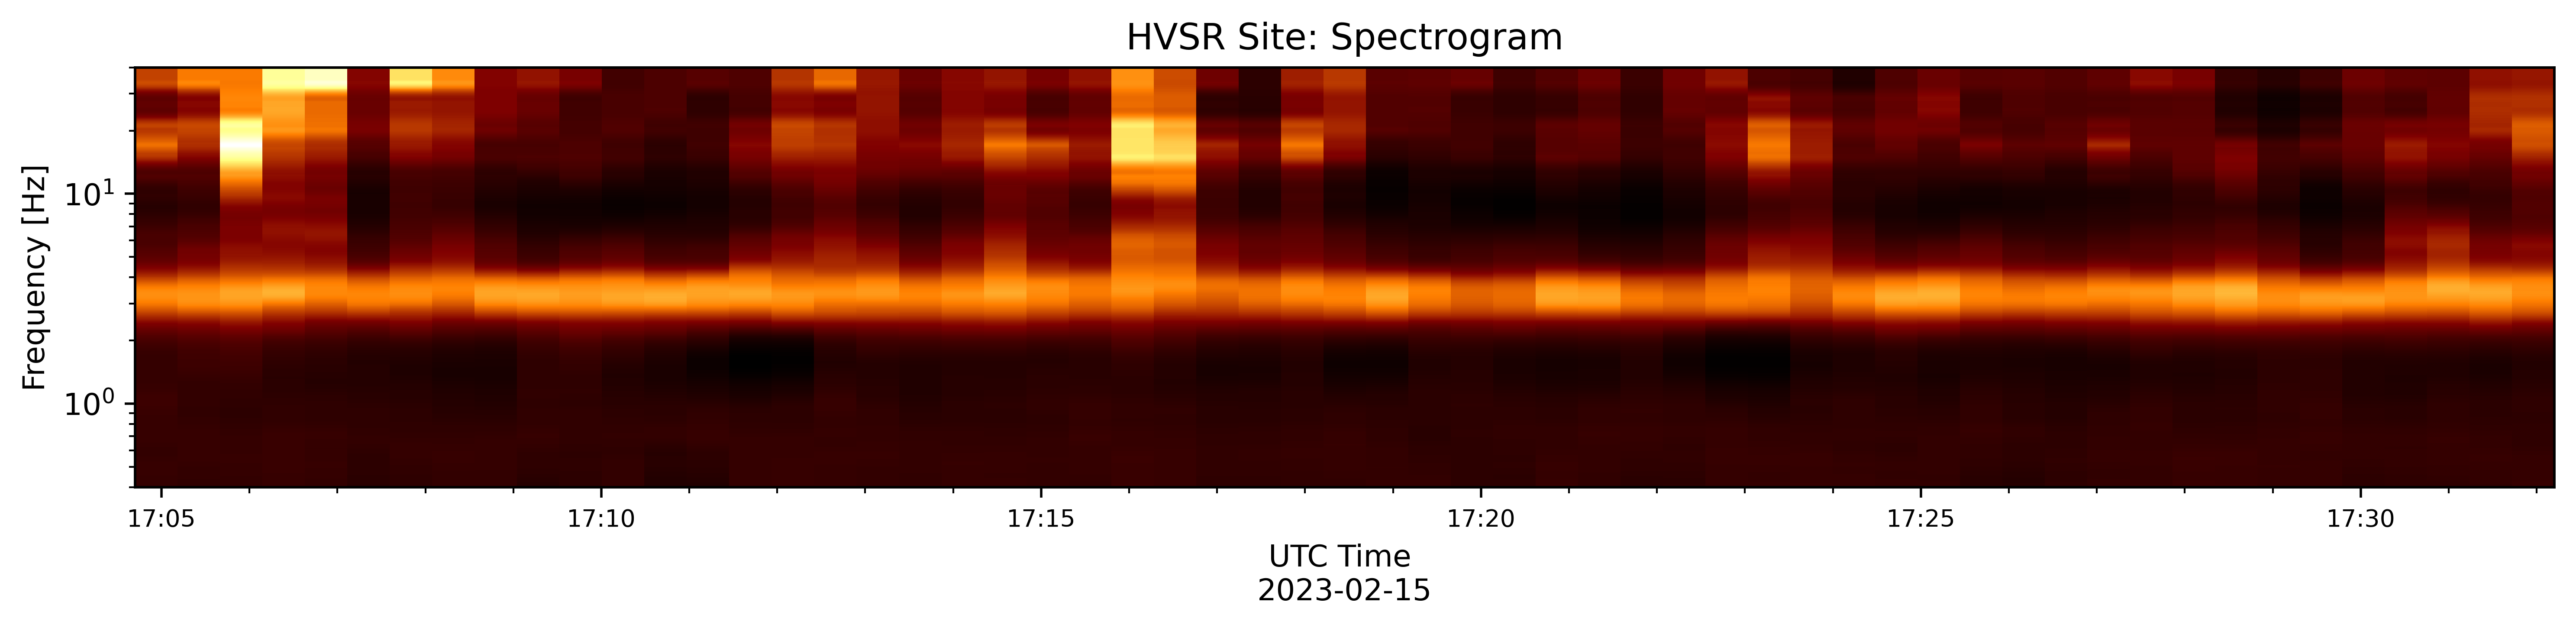

In [6]:
sprit.hvplot(hvsr_dict, kind='specgram', show=True)